## Laboratorio 3 – Clasificación

# Inicio

Estaremos tratando en este caso imagenes, de hojas, provenientes del conjunto de datos de CALTECH de la dirección:
http://www.vision.caltech.edu/Image_Datasets/leaves/leaves.tar

Si explora la página inicial (raiz hasta Image_Datasets) podrá observar que poseen otros datasets para poder hacer investigación a su propia manera.

Este dataset es creado por Markus Weber quien fue un estudiante de PhD de Caltech de Pietro Perona.

Aproximadamente el dataset contiene 186 imagenes de hojas a traves de diferentes fondos.  Se intentó normalizar las imagenes y estas estan en formato JPEG.

Fueron tomadas alrededor del campus de Caltech y son de 896 x 592 pixeles en tamaño.


Primero descarguemos la información del tar, para esto vamos a escribir código que nos ayude a esta función.

In [1]:
# instalamos esta dependencia que es necesaria en un punto
!pip install pillow
!pip install opencv-python

In [2]:
import os
from urllib.request import urlretrieve
import tempfile
import tarfile

# para tener repitividad en los resultados generados
np.random.seed(42)

# Creamos un directorio temporal
d = tempfile.mkdtemp()

# Definimos el URL
url = 'http://www.vision.caltech.edu/Image_Datasets/leaves/leaves.tar'

# Tenemos la data
fn, info = urlretrieve(url, os.path.join(d, 'leaves.tar'))

In [3]:
print("[INFO] Creada carpeta temporal en:", fn)
print("[INFO] Mi directorio actual de trabajo es:", os.getcwd())

[INFO] Creada carpeta temporal en: C:\Users\INGCOH~1\AppData\Local\Temp\tmpzkx5dxgm\leaves.tar
[INFO] Mi directorio actual de trabajo es: C:\Users\Ing Cohen\Desktop


In [4]:
myimagedir = os.path.join(os.getcwd(), 'leaves') 
if not os.path.exists(myimagedir):
    os.mkdir(myimagedir)
tar = tarfile.open(fn)
tar.extractall(path=myimagedir, members=None, numeric_owner=False)
tar.close()

Finalmente removemos el archivo y luego el directorio.  Adicionalmente removemos el README donde existe el archivo de hojas que no nos sirve de nada.

In [5]:
os.remove(fn)
os.rmdir(d)

readmepath = os.path.join(myimagedir, os.listdir(myimagedir)[-1])
os.remove(readmepath)

Ahora vamos a crear un archivo para marcar las etiquetas.  Este archivo estará compuesto de las clases.  Asumiremos lo siguiente:

0 = 5 Puntas

1 = 3 Puntas, Tipo 1

2 = 3 Puntas, Tipo 2

Si al final de generar abrimos el archivo veremos que esta compuesto de 0's 1's y 2's en cada linea.

In [6]:
jpeglist = os.listdir(myimagedir)

i = 0
with open('labels.txt', 'w') as lbl:
    for _ in jpeglist:
        i = i + 1
        if i <= 66:
            leafclass = 0
        if i > 66 and i <= 126:
            leafclass = 1
        if i > 126:
            leafclass = 2
        lbl.write(str(leafclass) + '\n')
lbl.close()

# LEAF DATASET

Ya que tenemos las etiquetas del sistema podemos transferirlas del archivo de texto a un arreglo de numpy.

In [126]:
# Leer el archivo de labels en un arreglo de numpy
import numpy as np
target = np.genfromtxt('labels.txt').astype(np.uint8)
target.shape

(186,)

Nuestra imagen es de (896 x 592), 3 canales y son alrededor de 186 imagenes

Primero procesaremos esto para convertirlo en un arreglo de numpy de (m, n) dimensiones.  Siendo m = ancho x largo x numero_de_canales

In [129]:
import os
import PIL
from PIL import Image 

w       = 896
h       = 592
nimages = 186
nchan   = 3
myimagedir = os.path.join(os.getcwd(), 'leaves')
imgarr   = np.zeros((w*h*nchan, nimages), dtype=np.uint8)
for index, filename in enumerate(os.listdir(myimagedir)):
    img = PIL.Image.open(os.path.join(myimagedir, filename))
    pixels = np.array(img).reshape(w*h*nchan)
    imgarr[:, index] = pixels

In [ ]:
'''
w       = 896
h       = 592
nimages = 186
nchan   = 3

imgarr   = np.zeros((w*h, nimages, nchan), dtype=np.uint8)
for index, filename in enumerate(os.listdir(myimagedir)):
    img = PIL.Image.open(os.path.join(myimagedir, filename))
    r, g, b = img.split()
    imgarr[:, index, 0] = np.array(r).reshape(w*h)
    imgarr[:, index, 1] = np.array(g).reshape(w*h)
    imgarr[:, index, 2] = np.array(b).reshape(w*h)
'''

In [130]:
imgarr.shape, pixels.shape

((1591296, 186), (1591296,))

Ahora intentaremos graficar alguna hoja aleatoria de la base de datos para saber si conseguimos el resultado esperado.

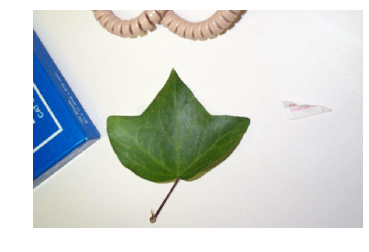

In [131]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import randint

# Ahora imprimiremos una hoja aleatorea
some_leaf = imgarr[:, randint(0, 185)].reshape(592, 896, 3)
plt.imshow(some_leaf)
plt.axis("off")

plt.show()

In [ ]:
'''
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import randint

# Ahora imprimiremos una hoja aleatorea
some_leaf = imgarr[:, randint(0, 185), :].reshape(592, 896, 3)
plt.imshow(some_leaf)
plt.axis("off")

plt.show()
'''

Para hacer balanceado el dataset, si se observa en la carpeta son alrededor de:
    
66 hojas de clase 0 (5 puntas)

60 hojas de clase 1 (3 puntas tipo 1)

60 hojas de clase 2 (3 puntas tipo 2).

Gracias al trabajo anterior es fácil dividir el dataset en estos conjuntos y agruparlos por medio de numpy.

In [133]:
# Como todas las clases tienen 59 datos, vamos a emparejarlas solamente para poder dividir mejor el dataset 
X = imgarr
Y = target
Y = np.hstack((Y[:60], Y[66:]))
X = np.hstack((X[:, :60], X[:, 66:]))
X.shape, Y.shape

((1591296, 180), (180,))

Dividimos el traning set y el test set manualmente.  

Por ejemplo, el dataset actualmente consta de 180 imagenes pues eliminamos las 6 imagenes para balancearlo (no se refiere a balancear el dataset, sinlo la cuenta de elementos de prueba clase 0, 1 y 2).

Las imagenes se separan de:

Training de 0 a 48, 60 a 108 y 120 a 168.

Las ultimas 12 restantes de cada sección corresponderán al test set para realizar las predicciones.

In [134]:
# Dividimos ahora el training set y el test set
nimginclass = 60
train = int(0.8*60)
test = 60 - train

# La primera clase va de 0 a 59, la segunda de 60 a 119 y la ultima de 120 a 179
# Sin embargo son de 0 a 47 imagenes de training y de 48 a 59 para test para cada clase
Xtrain = np.hstack((X[:,   :48], X[:, 60:(60+48)], X[:, 120:(120+48)]))/255
Xtest  = np.hstack((X[:, 48:(48+12)], X[:, (60+48):(60+48+12)], X[:, (120+48):]))/255
Ytrain = np.hstack((Y[:48], Y[60:(60+48)], Y[120:(120+48)]))
Ytest  = np.hstack((Y[48:(48+12)], Y[(60+48):(60+48+12)], Y[(120+48):]))


print("Existen {} imagenes de training en una clase y {} imagenes de prueba en cada clase para un total de {} imagenes por clase".format(train, test, nimginclass))

Existen 48 imagenes de training en una clase y 12 imagenes de prueba en cada clase para un total de 60 imagenes por clase


In [135]:
Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape

((1591296, 144), (1591296, 36), (144,), (36,))

# Clasificación Multiclase

Ahora utilizaremos un gradiente descendente estocastico y ajustaremos algunos hiperparámetros para conseguir siempre el mismo resultado cada vez que ejecutemos el workbook.

In [136]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(Xtrain.T, Ytrain)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [137]:
Ypredict = sgd_clf.predict(Xtest.T)
Ypredict, Ytest

(array([1, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=uint8))

No está tan mal.  Para ser un batch de 36 imagenes de prueba y 144 imagenes de training solamente el resultado se apega bastante a la realidad. 

Ahora exploraremos la métrica de cross_validation para observar que tan bien o mal lo hizo nuestro dataset.

In [138]:
#from sklearn.model_selection import cross_val_score
#Yscores = cross_val_predict(sgd_clf, Xtrain.T, Ytrain, cv=3, method="decision_function")

Ahora utilizaremos una métrica para el rendimiento de la predicción llamada validación cruzada.  Esta función evalua el modelo utilizado usando validación cruzada con k-fold y en este caso son 3.

Esto quiere decir que un k-fold divide el training set en 3 k-folds realizando las predicciones y evaluando cada una de ellas usando el modelo entrenado de los folds pendientes.

In [139]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

kfold = StratifiedKFold(n_splits=3, random_state=42)

for xindex, yindex in kfold.split(Xtrain.T, Ytrain):
    clonemodel  = clone(sgd_clf)
    Xtrainfold = Xtrain.T[xindex]
    Ytrainfold = (Ytrain[xindex])
    Xtestfold  = Xtrain.T[yindex]
    Ytestfold  = (Ytrain[yindex])

    clonemodel.fit(Xtrainfold, Ytrainfold)
    prediction = clonemodel.predict(Xtestfold)
    numok = sum(prediction == Ytestfold)
    print(numok / len(prediction))

0.3125
0.3958333333333333
0.7291666666666666


Lo mismo que lo anterior, evalua la misma métrica.  Note que da el mismo valor.

In [141]:
cross_val_score(sgd_clf, Xtrain.T, Ytrain, cv=3, scoring="accuracy")

array([0.3125    , 0.39583333, 0.72916667])

Una mejor manera de evaluar el modelo y su desempeño es a base de la matriz de confusión.

Esta matriz nos muestra cuantos elementos de, por ejemplo la clase 0, fueron clasificados como clase 1 o 2.

Lo correcto sería obtener una diagonal oscura, que simboliza que todos los elementos fueron clasificados correctamente.

Para realizar una matriz de confusión se deben poseer las predicciones y el set de etiquetas de entrenamiento.

También se puede evaluar las predicciones del test set pero lo común en proyectos de machine learning es usar el test set al final para realizar pruebas ya del modelo depurado.

In [142]:
from sklearn.metrics import confusion_matrix

confMat = confusion_matrix(Ytrain, Ytrainpredictions)
confMat

array([[ 6, 31, 11],
       [ 2, 36, 10],
       [ 2, 19, 27]], dtype=int64)

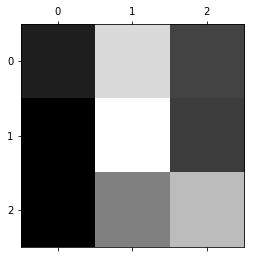

In [143]:
plt.matshow(confMat, cmap=plt.cm.gray)
plt.show()

Así como las validaciones crusadas de cross_val_score(), también la siguiente funcion cross_val_predict() puede realizar varias k-fold especificadas para validación cruzada.  

Sin embargo en vez de retornar los 'scores' retorna las 'predicciones' de cada k-fold.  

Se tienen predicciones que fueron hechas por el modelo y nunca vio la data durante el entrenamiento, lo cual es bueno a la hora de evaluación del modelo.

In [144]:
Ypredictions = cross_val_predict(sgd_clf, Xtrain.T, Ytrain, cv=3)

Solo de referencias de uso, validas solo para clasificación binaria.  Para clasficiacion binaria average='binary' o simplemente obviar el campo average, por defecto es binario.

## Métricas de Clasificación Binaria 

Si bien es cierto estas métricas no califican para un modelo multiclase, se explicará parte de su uso para entender mejor su desempeño sobre el modelo binario.

La precisión es la medición de los resultados positivos de tu modelo.

\begin{equation}
Precision = \frac{TP}{TP + FP}
\end{equation}

En donde:
 - TP = Verdaderos positivos o muestras que fueron clasificadas y catalogadas como debieron ser
 - FP = Falsos positivos o muestras que fueron clasificadas y catalogadas como de otra clase que no es la correspondiente.

In [116]:
precision_score(Ytrain, Ypredictions, average='micro')

0.4791666666666667

También se usa la siguiente métrica llamada 'recall' que es el radio de los verdaderos positivos y falsos negativos

\begin{equation}
Recall = \frac{TP}{TP + FN}
\end{equation}

En donde:
 - FN = Falsos negativos 

In [146]:
recall_score(Ytrain, Ypredictions, average='micro')

0.4791666666666667

Frecuentemente también se combinan la precision y el recall para una sola métrica llamada F1 Score

Esta representa la media armónica de precision y recall.  Las medidas regulares de precision y recal dan medias o pesos equitativos, sin embargo el F1 da una medida armónica que valora más en peso a sus valores bajos.  Como resultado el clasificador da un resultado alto si Recall y Precision son altos.

\begin{equation}
F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
\end{equation}


In [148]:
f1_score(Ytrain, Ypredictions, average='micro')

0.4791666666666667

In [149]:
# Solo funciona en clasificación binaria

#from sklearn.metrics import roc_auc_score
#roc_auc_score(Ytrain, Ypredictions)

#from sklearn.metrics import precision_recall_curve
#precisions, recalls, thresholds = precision_recall_curve(Ytrain, Yscores)

#from sklearn.metrics import roc_curve
#precisions, recalls, thresholds = roc_curve(Ytrain, Yscores)

# Clasificador Binario a base del Dataset MNIST

Su labor será realizar un clasificador binario digitos.  Es decir, realizará un clasificador binario utilizando MNIST que posee digitos del 0 al 9, sin embargo intentará clasificar solo un dígito, el número 7.

Es decir, su clasificador hará la siguiente acción

0 -> modelo -> no es 7

1 -> modelo -> no es 7
.
.
.
7 -> modelo -> es 7
.
.
9 -> modelo -> no es 7


Seguir las siguiente s instrucciones

- Descargar el MNIST dataset utilizando python (10s)
- Realizar dos modelos (20 pts)
  - KNN
  - RandomForest
- Decidir cual es el mejor modelo (10 pts)
- Crear una matriz de confusion (10 pts)
- Calcular la precision, recall, threshold con precision_recall_curve() (10 pts)
- Graficar precision vs recall (10 pts)
- Graficar precision vs threshold (10 pts)
- Graficar recall vs threshold (10 pts)
- Graficar curva ROC (10 pts)